# Step 1: Data Analysis & Dataset Sample

## 1.1 Data Acquisition

The dataset used in this project is the [Fruits 360 dataset](https://www.kaggle.com/datasets/moltean/fruits), publicly available on Kaggle. It contains thousands of labeled fruit images in `.jpg` format, sorted into folders by fruit class. Each image is **100×100 pixels** and originally in **RGB format**.

We selected this dataset because:
- It includes a **wide variety of fruit classes** suitable for multi-class classification.
- Images are already **clean and labeled**, minimizing preprocessing effort.
- It is a well-known benchmark dataset for fruit classification tasks.
- The folder structure is compatible with **PyTorch’s `ImageFolder`**, making it easy to load.

---

## 1.2 Dataset Reduction & Cleaning

To simulate a more realistic and constrained edge-case scenario, we **manually selected 8 specific fruit categories** from the dataset. This allows us to:
- Focus the classification task on a smaller, balanced subset.
- Reduce dataset size for faster training and evaluation.
- Better explore model performance in a **low-data regime**.

We ensured that:
- The image dimensions are consistent (**100×100**).
- All images are intact and correctly labeled.
- Class balance is maintained across training and test splits.

Additionally, during preprocessing, all images are converted to **grayscale** to reduce input complexity and align with embedded system constraints.

---

## 1.3 Exploratory Data Analysis (EDA)

To confirm that our selected subset is suitable for fair training, we examined the **class distribution** using simple utility functions.

### Count Function:
```python
def count_images_per_class(directory):
    return {
        class_name: len(os.listdir(os.path.join(directory, class_name)))
        for class_name in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, class_name))
    }

In [1]:
import os, sys
sys.path.append(os.path.abspath("../src"))

from data import count_images_per_class, quick_image_sanity_check
from viz import display_class_distribution
from utils import seed_everything


In [2]:
seed_everything(42)

# Dataset paths
TRAIN_DIR = '../Dataset/Training'
TEST_DIR  = '../Dataset/Test'

# Create figure output folder
os.makedirs("reports/figures", exist_ok=True)


[INFO] Global seed set to 42



Training Set Distribution
-------------------------
Apple Red 1: 492 images
Avocado 1: 427 images
Banana 1: 490 images
Kaki 1: 490 images
Orange 1: 479 images
Pineapple 1: 490 images
Strawberry 1: 492 images
Tomato 1: 738 images


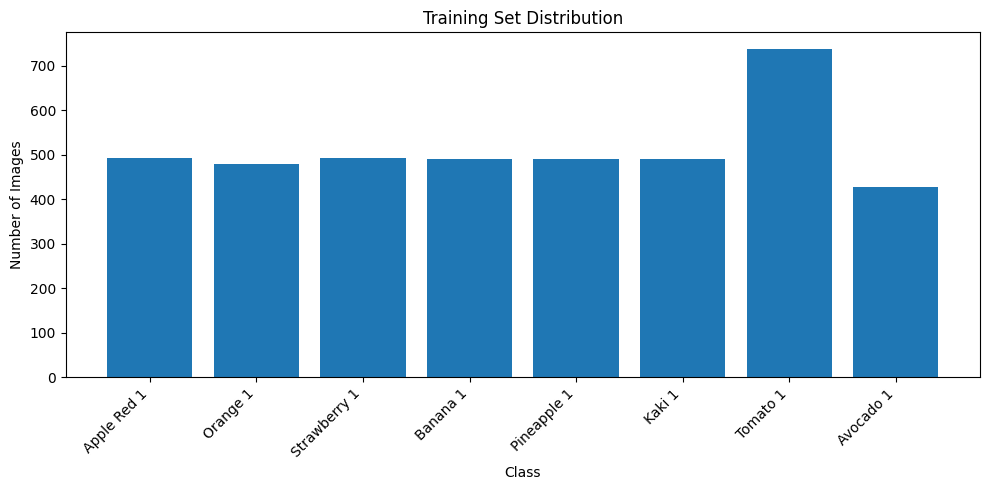


Test Set Distribution
---------------------
Apple Red 1: 164 images
Avocado 1: 143 images
Banana 1: 166 images
Kiwi 1: 156 images
Orange 1: 160 images
Pineapple 1: 166 images
Strawberry 1: 164 images
Tomato 1: 246 images


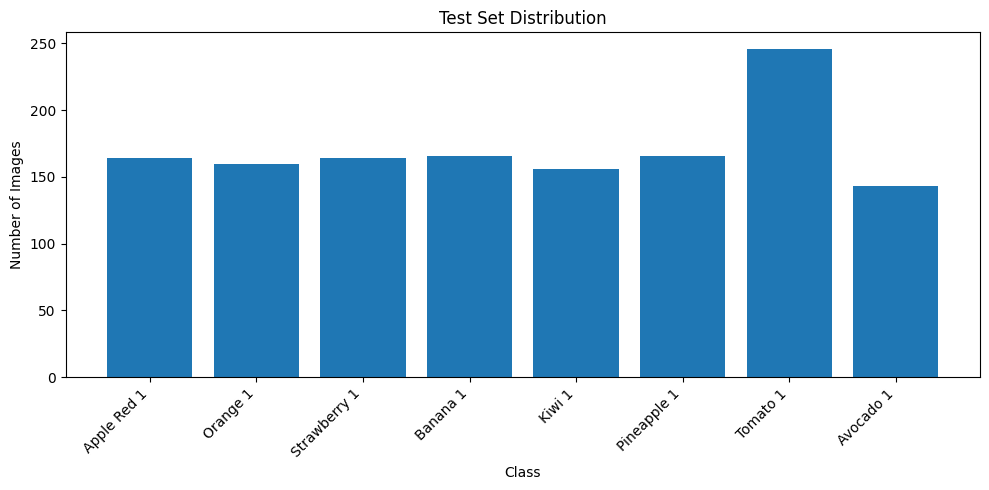

Sanity mismatches (train): {'bad_size': 0, 'bad_mode': 0}
Sanity mismatches (test): {'bad_size': 0, 'bad_mode': 0}


In [3]:
# Compute counts
train_counts = count_images_per_class(TRAIN_DIR)
test_counts  = count_images_per_class(TEST_DIR)

# Show + save plots
display_class_distribution(
    train_counts,
    title="Training Set Distribution",
    save_path="reports/figures/train_distribution.png"
)
display_class_distribution(
    test_counts,
    title="Test Set Distribution",
    save_path="reports/figures/test_distribution.png"
)

# Optional sanity check
m_train = quick_image_sanity_check(TRAIN_DIR, expect_size=(100, 100))
m_test  = quick_image_sanity_check(TEST_DIR,  expect_size=(100, 100))
print("Sanity mismatches (train):", m_train)
print("Sanity mismatches (test):",  m_test)
